# El problema

Una empresa de bicicletas compartidas que opera en el área de una ciudad específica. tiene un esquema de funcionamiento en el cual los usuarios pueden alquilar una bicicleta desde un lugar en particular y devolverla en un lugar diferente utilizando su infraestructura.

El problema consiste en predecir cuántas bicicletas se van a utilizar en el futuro. Para ello se nos facilita un archivo  [csv](https://drive.google.com/file/d/1k_Qag1aJcVCrg-ENDJl3FPCHrtBKCczE/view?usp=sharing) donde aparecen el número de bicicletas contratadas todos los días y las variables metereológicas de esos días.

Se usará análisis de regresión con el fin de capturar la relación entre características y número de bicicletas contratadas en un modelo.


# 0. Carga de Datos

Cargaremos los datos de la misma forma que lo hemos hecho otras veces en Google Collaboratory.


In [1]:
# 0. load data from file
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving bikes.csv to bikes.csv
User uploaded file "bikes.csv" with length 54187 bytes


Posteriomente lo cargamos en un DataFrame de Pandas con el nombre de *bikes*

In [2]:
# 0. load data in DataFrame
import pandas as pd
import io
bikes = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')),
                    index_col = 'date')
bikes.head()

,temperature,humidity,windspeed,count
date,,,,
2011-01-03,2.716070,45.715346,21.414957,120.0
2011-01-04,2.896673,54.267219,15.136882,108.0
2011-01-05,4.235654,45.697702,17.034578,82.0
2011-01-06,3.112643,50.237349,10.091568,88.0
2011-01-07,2.723918,49.144928,15.738204,148.0


In [ ]:
bikes.describe()

,temperature,humidity,windspeed,count
count,729.000000,729.000000,729.000000,729.000000
mean,17.762024,56.514591,17.241418,622.818930
std,8.921313,7.348730,5.222353,383.958772
min,-2.200000,21.300000,5.300000,2.000000
25%,10.066578,51.561669,13.462096,256.333333
50%,18.087694,56.546144,16.656522,639.000000
75%,25.455587,61.423987,20.320807,891.666667
max,35.100000,75.600000,35.200000,1820.000000


Posteriormente seleccionamos las variables con las que trabajar.

Es muy importante seleccionar las características cuando se va a resolver un problema mediante kNN ya que muchas variables pueden distorsionar el resultado del algoritmo que está basado en la distancia.

Para realizar esta selección vamos a utilizar la correlación entre cada una de las características y la variable a predecir.



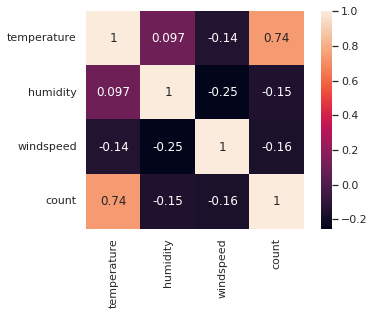

In [ ]:
import seaborn as sns

sns.set()
sns.heatmap(bikes.corr(), square=True, annot=True)

En este caso de entre las tres posibles, seleccionamos aquellas que previamente mediante análisis de correlaciones, y o análisis mediante árboles de decisión o random forests nos han dado un valor superior.

Además vamos a dividir nuestro conjunto de datos en dos partes una para entrenamiento (tuning) y otra para test. Para ello vamos a utilizar los datos de 2011 y la mitad de 2012 para entrenamiento y el resto de 2012 para los tests.  

In [ ]:
# 0.1 features and labels
df = bikes[['temperature', 'humidity', 'count']]

train = df.loc['2011-01-01':'2012-06-30']
test  = df.loc['2012-07-01':]

test.head()



,temperature,humidity,count
date,,,
2012-07-01,32.657877,47.038591,879.0
2012-07-02,31.788635,46.263092,904.0
2012-07-03,31.747210,48.775688,1052.0
2012-07-04,32.906207,47.821851,1228.5
2012-07-05,34.065205,46.868013,1405.0


#1. Parametrización

Existen diferentes parámetros para método basado en los vecinos más cercanos utilizando scikit-learn



*   **KNeighbors/Radius**: KNeihgbors está basado en el estudio de los k vecinos más cercanos para cada punto, mientras que RadiusNeighboors están basados en un conjunto de vecinos que están dentro de un radio. **Nuestra elección es la primera**, la segunda sería útil cuando los datos no estuvieran muestreados de forma uniforme.
* **K/Radio**
    * k: Un número k mayor suprime el eecto del ruido pero hace a los límites de clasificación más distintos.
    * Radios, un radio fijo es muy adecuado cuando los datos están muy dispersos (sprarse neighboors
*   **Pesos** : dos posibles valores, "uniform" cada vecino tiene el mismo peso, weights se asigna un peso a cada vecino proporcional a la distancia que esté del elemento referencia. También se puede definir una dfunción por parte del usuario

Nuestra elección KNeighbors y k y pesos se van a parametrizar para ello se ejecutará [validación cruzada]([https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada) y como medida de éxito vamos a utilizar [MAE](https://es.wikipedia.org/wiki/Valor_absoluto)


In [ ]:
# reseteamos el index con el fin de evitar problemas en la validación cruzada
train.reset_index(drop = True, inplace = True)
train.head()

,temperature,humidity,count
0,2.716070,45.715346,120.0
1,2.896673,54.267219,108.0
2,4.235654,45.697702,82.0
3,3.112643,50.237349,88.0
4,2.723918,49.144928,148.0


Min Value uniform : 185.57078703703706 (4)
Min Value distance : 184.94736590327204 (4)


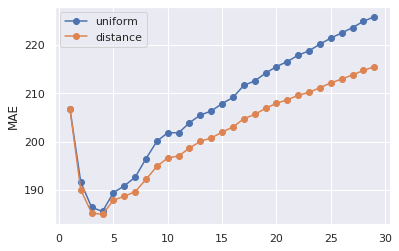

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = TimeSeriesSplit(n_splits = 5) #


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train):
          # División train test aleatoria
          f_train = train.loc[train_fold]
          f_test = train.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(['count'], axis=1),
                               y = f_train['count'])
          y_pred = knn.predict(X = f_test.drop(['count'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['count'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

   plt.plot(range(1,len(total_scores)+1), total_scores,
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')


plt.legend()
plt.show()



# 2. Construcción y ejecución del modelo



Una vez que hemos identificado la mejor parametrización vamos a pasar a hacer una ejecución del modelo y vamos graficar sus resultados.

Recordamos que al final del paso 1 hemos dividido en entrenamiento/tuneado y test

Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente

In [ ]:
# constructor
n_neighbors = 4
weights = 'distance'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights)
# fit and predict

knn.fit( X = train.drop(['count'], axis=1), y = train['count'])
y_pred = knn.predict(X = test.drop(['count'], axis = 1))
mae = mean_absolute_error(test['count'], y_pred)
print ('MAE', mae)



MAE 243.38113742041674


Y guardamos el fichero de resultados en nuestro disco.

In [ ]:
# round the result and cast to int
import numpy as np
res = np.rint(y_pred) # round
res = res.astype(int) # cast to int
# generate output
output = pd.DataFrame({ 'date': test.index, 'result': res})


from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)


files.download('result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Por último probamos visualizamos como ha quedado nuestra predicción con la realidad.

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


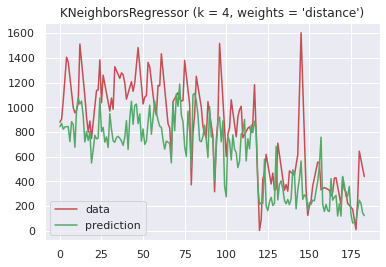

In [ ]:

from sklearn.metrics import mean_absolute_error


# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(test['count'].shape[0]))
plt.plot(xx, test['count'], c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()